In [1]:
from pathlib import Path
import os
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
from skimage import measure, segmentation, morphology
import cv2
from glob import glob
import numpy as np
from microfilm import microplot

## User Interface

### You need to run this with the absolute path

In [4]:
DATA_DIR = Path("/data/ishang/CCNB1-dataset/") # NEEDS TO BE ABSOLUTE PATH
VIZ_DIR = Path("/home/ishang/HPA-embedding/dev-dataset") # NEEDS TO BE ABSOLUTE PATH
DATA_DIR_STR, VIZ_DIR_STR = str(DATA_DIR), str(VIZ_DIR)
DATA_FOLDER_PATH, VIZ_FOLDER_PATH = "data-folder.txt", "viz-folder.txt"
CHANNEL_NAMES = ["cyclinb1", "microtubule", "nuclei"]
DAPI = 2
TUBL = 1
ANLN = None

In [5]:
!find $DATA_DIR_STR -type d > $DATA_FOLDER_PATH
!sed -i '1d' $DATA_FOLDER_PATH
!cat $DATA_FOLDER_PATH | wc -l
!find $VIZ_DIR_STR -type d > $VIZ_FOLDER_PATH
!sed -i '1d' $VIZ_FOLDER_PATH
!cat $VIZ_FOLDER_PATH

1714
/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00
/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01
/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0


## Mask Creation

### DO NOT RERUN THIS CELL BELOW!!! YOU WILL HAVE TO KILL THE PROCESS AND RESTART THE KERNEL

In [6]:
pwd = Path(os.getcwd())
NUC_MODEL = pwd / "HPA-Cell-Segmentation" / "nuclei-model.pth"
CELL_MODEL = pwd / "HPA-Cell-Segmentation" / "cell-model.pth"

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
segmentator = cellsegmentator.CellSegmentator(
    str(NUC_MODEL), str(CELL_MODEL), device="cuda:1", padding=True, multi_channel_model=(ANLN is not None)
)

please compile abn


/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can

### DO NOT RERUN THIS ^^^^^ YOU WILL HAVE TO KILL THE PROCESS AND RESTART THE KERNEL

In [8]:
def image_paths_from_folders(folders_file):
    image_paths = list(open(folders_file, "r"))
    image_paths = [Path(x.strip()) for x in image_paths]
    return image_paths
image_paths = image_paths_from_folders(DATA_FOLDER_PATH)
viz_image_paths = image_paths_from_folders(VIZ_FOLDER_PATH)
print(image_paths)

[PosixPath('/data/ishang/CCNB1-dataset/B_6--Stage09'), PosixPath('/data/ishang/CCNB1-dataset/B_1--Stage38'), PosixPath('/data/ishang/CCNB1-dataset/D_3--Stage03'), PosixPath('/data/ishang/CCNB1-dataset/C_5--Stage08'), PosixPath('/data/ishang/CCNB1-dataset/D_1--Stage03'), PosixPath('/data/ishang/CCNB1-dataset/C_6--Stage19'), PosixPath('/data/ishang/CCNB1-dataset/B_4--Stage23'), PosixPath('/data/ishang/CCNB1-dataset/D_3--Stage00'), PosixPath('/data/ishang/CCNB1-dataset/11_TileScan 6--Stage29'), PosixPath('/data/ishang/CCNB1-dataset/field--X03--Y02_image--L0000--S00--U01--V00--J17--E02--O02--X03--Y02--T0000--Z00--C0'), PosixPath('/data/ishang/CCNB1-dataset/field--X02--Y03_image--L0000--S00--U09--V01--J17--E02--O02--X02--Y03--T0000--Z00--C0'), PosixPath('/data/ishang/CCNB1-dataset/C_3--Stage43'), PosixPath('/data/ishang/CCNB1-dataset/field--X01--Y00_image--L0000--S00--U08--V03--J17--E02--O02--X01--Y00--T0000--Z00--C0'), PosixPath('/data/ishang/CCNB1-dataset/field--X03--Y00_image--L0000--S00

In [9]:
def get_masks(segmentator, image_paths):
    """
    Get the masks for the images in image_paths using HPA-Cell-Segmentation
    It places all the cells in the target directory from image_paths into a single
    """
    nuclei_mask_paths = []
    cell_mask_paths = []
    for image_path in image_paths:
        if (image_path / "cell_mask.npy").exists() and (image_path / "nuclei_mask.npy").exists():
            nuclei_mask_paths.append(image_path / "nuclei_mask.npy")
            cell_mask_paths.append(image_path / "cell_mask.npy")
            continue
        glob_channel_images = lambda image_path, c: list(glob(f"{str(image_path)}/**/*{CHANNEL_NAMES[c]}.png", recursive=True))
        dapi_paths = sorted(glob_channel_images(image_path, DAPI))
        tubl_paths = sorted(glob_channel_images(image_path, TUBL))
        anln_paths = sorted(glob_channel_images(image_path, ANLN)) if ANLN is not None else None
        
        for dapi, tubl in zip(dapi_paths, tubl_paths):
            assert str(dapi).split(CHANNEL_NAMES[DAPI])[0] == str(tubl).split(CHANNEL_NAMES[TUBL])[0], f"File mismatch for {dapi} and {tubl}"
        if ANLN is not None and anln_paths is not None:
            for dapi, anln in zip(dapi_paths, anln_paths):
                assert str(dapi).split(CHANNEL_NAMES[DAPI])[0] == str(anln).split(CHANNEL_NAMES[ANLN])[0], f"File mismatch for {dapi} and {anln}"

        load_image = lambda path_list: [cv2.imread(str(x), cv2.IMREAD_UNCHANGED) for x in path_list]
        dapi_images = load_image(dapi_paths)
        tubl_images = load_image(tubl_paths)
        anln_images = load_image(anln_paths) if anln_paths is not None else None

        images = [tubl_images, anln_images, dapi_images]
        nuc_segmentation = segmentator.pred_nuclei(images[2])
        cell_segmentation = segmentator.pred_cells(images)

        # post-processing
        nuclei_mask = label_nuclei(nuc_segmentation[0])
        nuclei_mask, cell_mask = label_cell(
            nuc_segmentation[0], cell_segmentation[0]
        )

        # apply preprocessing mask if the user want to merge nuclei
        # in preprocess_masks get_single_cell_mask

        assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch for {image_path}, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"
        assert np.max(nuclei_mask) > 0 and np.max(cell_mask) > 0, f"No nuclei or cell mask found for {image_path}"
        np.save(image_path / "nuclei_mask.npy", nuclei_mask)
        np.save(image_path / "cell_mask.npy", cell_mask)
        nuclei_mask_paths.append(image_path / "nuclei_mask.npy")
        cell_mask_paths.append(image_path / "cell_mask.npy")
    return nuclei_mask_paths, cell_mask_paths

In [10]:
!tree $VIZ_DIR

/home/ishang/HPA-embedding/dev-dataset
├── 10_R1--Stage01
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
├── 11_TileScan 6--Stage00
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
└── field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0
    ├── cell_mask.npy
    ├── cyclinb1.png
    ├── microtubule.png
    ├── nuclei_mask.npy
    └── nuclei.png

3 directories, 15 files


In [11]:
nuclei_mask_paths, cell_mask_paths = get_masks(segmentator, viz_image_paths)
print(nuclei_mask_paths, cell_mask_paths)
!tree $VIZ_DIR

[PosixPath('/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00/nuclei_mask.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01/nuclei_mask.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0/nuclei_mask.npy')] [PosixPath('/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00/cell_mask.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01/cell_mask.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0/cell_mask.npy')]
/home/ishang/HPA-embedding/dev-dataset
├── 10_R1--Stage01
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
├── 11_TileScan 6--Stage00
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
└── field--X01--Y00_image--L0000--S00--

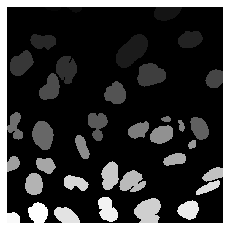

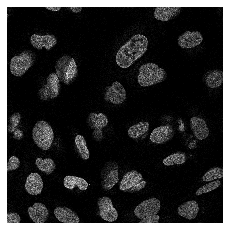

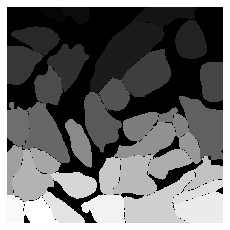

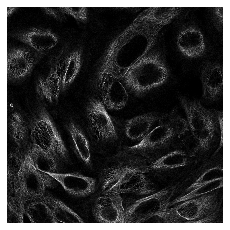

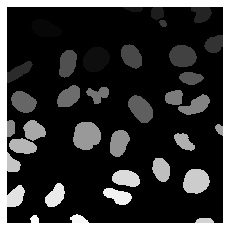

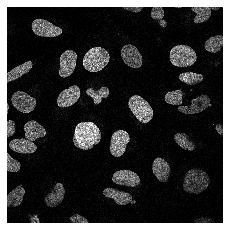

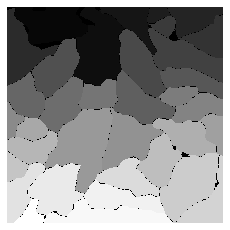

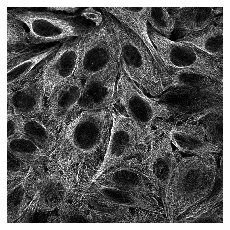

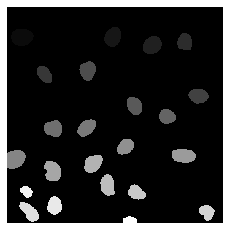

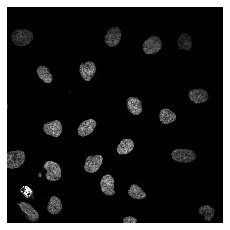

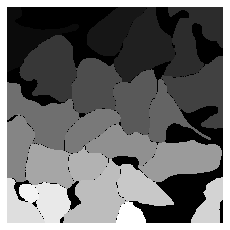

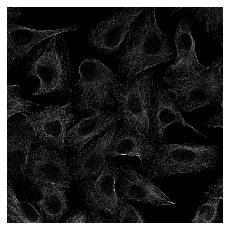

In [9]:
for nuclei_path, cell_path, image_path in zip(nuclei_mask_paths, cell_mask_paths, viz_image_paths):
    sample_nuclei_mask = np.load(nuclei_path)
    sample_nuclei = cv2.imread(str(image_path / (CHANNEL_NAMES[DAPI] + ".png")), cv2.IMREAD_UNCHANGED)
    microplot.microshow(sample_nuclei_mask)
    microplot.microshow(sample_nuclei)

    sample_cell_mask = np.load(cell_path)
    sample_microtuble = cv2.imread(str(image_path / (CHANNEL_NAMES[TUBL] + ".png")), cv2.IMREAD_UNCHANGED)
    microplot.microshow(sample_cell_mask)
    microplot.microshow(sample_microtuble)

In [21]:
def merge_nuclei(nuclei_mask, cell_mask, dialation_radius=20):
    bin_nuc_mask = (nuclei_mask > 0).astype(np.int8)
    cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(dialation_radius))
    # get the labels of touching nuclei
    new_label_map = morphology.label(cls_nuc)
    new_label_idx = np.unique(new_label_map)[1:]

    new_cell_mask = np.zeros_like(cell_mask)
    new_nuc_mask = np.zeros_like(nuclei_mask)
    for new_label in new_label_idx:
        # get the label of the touching nuclei
        old_labels = np.unique(nuclei_mask[new_label_map == new_label])
        old_labels = old_labels[old_labels != 0]

        new_nuc_mask[np.isin(nuclei_mask, old_labels)] = new_label
        new_cell_mask[np.isin(cell_mask, old_labels)] = new_label

        # for old_label in old_labels:
        #     new_cell_mask[cell_mask == old_label] = new_label
        #     new_nuc_mask[nuclei_mask == old_label] = new_label
    return new_nuc_mask, new_cell_mask

def clean_cell_masks(
    cell_mask,
    nuclei_mask,
    rm_border=True, # removes cells touching the border
    remove_size=1000, # remove cells smaller than remove_size, based on the area of the bounding box, honestly could be higher, mb 2500. Make 0 to turn off.
    dialation_radius=20, # this is for 2048x2048 images adjust as needed. Make 0 to turn off.
    # final_size=None, # resize the mask to final_size
):
    num_removed = 0
    if rm_border:
        cleared_nuclei_mask = segmentation.clear_border(nuclei_mask)
        keep_value = np.unique(cleared_nuclei_mask)
        bordering_cells = np.array([[x_ in keep_value for x_ in x] for x in cell_mask]).astype("uint8")
        cleared_cell_mask = cell_mask * bordering_cells
        num_removed = len(np.unique(nuclei_mask)) - len(keep_value)  # -1 because 0 is not a cell
        if num_removed == np.max(nuclei_mask):
            assert np.max(keep_value) == 0, f"Something went wrong with clearing the border, num_removed is the same as the highest index mask in nuclei mask, but the keep_value {np.max(keep_value)} != 0"
        nuclei_mask = cleared_nuclei_mask
        cell_mask = cleared_cell_mask

    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask))

    # needs to be after clear border otherwise you get a boundary of nuclei that are still touching the edge
    # maybe that is due to the interpolation method
    # ideally this happens outside
    # if final_size is not None:
    #     nuclei_mask = cv2.resize(nuclei_mask, final_size, interpolation=cv2.INTER_NEAREST)
    #     cell_mask = cv2.resize(cell_mask, final_size, interpolation=cv2.INTER_NEAREST)

    ### see if nuclei are touching and merge them
    if dialation_radius > 0:
        nuclei_mask, cell_mask = merge_nuclei(nuclei_mask, cell_mask, dialation_radius=dialation_radius)
        assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask))
    else:
        cell_mask = cell_mask
        nuclei_mask = nuclei_mask

    region_props = measure.regionprops(cell_mask, (cell_mask > 0).astype(np.uint8))
    pre_size = len(region_props)
    if remove_size > 0:
        region_props = [x for x in region_props if x.area > remove_size]
        num_removed += pre_size - len(region_props)
    bbox_array = np.array([x.bbox for x in region_props])

    # convert x1,y1,x2,y2 to x,y,w,h
    bbox_array[:, 2] = bbox_array[:, 2] - bbox_array[:, 0]
    bbox_array[:, 3] = bbox_array[:, 3] - bbox_array[:, 1]

    # com_array = np.array([x.weighted_centroid for x in region_props])

    return cell_mask, nuclei_mask, bbox_array, num_removed

ValueError: too many values to unpack (expected 4)

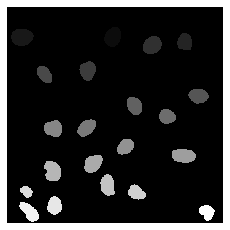

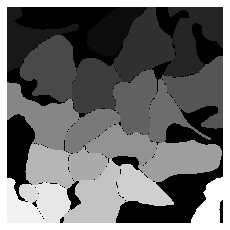

In [23]:
rm_border=True # removes cells with nuclei touching the border
remove_size=2500 # remove cells smaller than remove_size, based on the area of the bounding box, honestly could be higher, mb 2500. Make 0 to turn off.
dialation_radius=0 # this is for 2048x2048 images adjust as needed. Make 0 to turn off.

def save_single_cell_image(
    cell_mask_path,
    nuclei_mask_path,
):
    cell_mask = np.load(cell_mask_path)
    nuclei_mask = np.load(nuclei_mask_path)

    num_original = len(np.unique(nuclei_mask))
    new_cell_mask, new_nuc_mask, bbox_array, num_removed = get_single_cell_masks(
        cell_mask,
        nuclei_mask,
        rm_border=rm_border,
        remove_size=remove_size,
        dialation_radius=dialation_radius,
    )
    return new_cell_mask, new_nuc_mask, bbox_array, num_removed, num_original

total_num_removed = 0
total_num_original = 0
for cell_mask_path, nuclei_mask_path, image_path in zip(cell_mask_paths, nuclei_mask_paths, image_paths):
    microplot.microshow(nuclei_mask)
    microplot.microshow(cell_mask)
    cell_mask, nuclei_mask, _, n_removed, n_original = save_single_cell_image(cell_mask_path, nuclei_mask_path)
    total_num_removed += n_removed
    total_num_original += n_original
    microplot.microshow(nuclei_mask)
    microplot.microshow(cell_mask)
    cell_image = np.asarray(cv2.imread(str(image_path / (CHANNEL_NAMES[TUBL] + ".png")), cv2.IMREAD_UNCHANGED))
    nuclei_image = np.asarray(cv2.imread(str(image_path / (CHANNEL_NAMES[DAPI] + ".png")), cv2.IMREAD_UNCHANGED))
    image = np.stack([cell_image, nuclei_image])
    microplot.microshow(image, cmaps=["pure_red", "pure_blue"])
    microplot.microshow(image * (cell_mask > 0)[None, ...], cmaps=["pure_red", "pure_blue"])
print("fraction removed:", total_num_removed / total_num_original)